Note: this notebook is written to work in Colab, and thus it installs the `eigenlearning` repo from Github. If the repo is already present on the system, the install cell can be skipped and the modules imported directly, and the saving to Drive can be replaced with saving locally.

Another note: we assembled these notebooks out of modular parts from other notebooks, and thus we have not run all of them. If something doesn't work, let us know and we'll be glad to know and happy to fix it.

# Imports and installs

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import os
import sys

if os.path.isdir('/content/eigenlearning'):
  !rm -r '/content/eigenlearning'
!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

     |████████████████████████████████| 92 kB 734 kB/s 


In [ ]:
import json
import math

import jax
from jax import grad
import jax.numpy as np
import jax.random as random

import matplotlib.gridspec as gridspec
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt

import numpy as basenp

In [ ]:
from utils import get_net_fns, net_predictions, kernel_predictions, mse
from measures import learning_measure_predictions, learning_measure_statistics, find_C
from unit_circle import unit_circle_eigenvalues, get_unit_circle_dataset
from hypercube import hypercube_eigenvalues, get_hypercube_dataset
from hypersphere import hypersphere_eigenvalues, get_hypersphere_dataset, hyp_har_multiplicity
from image_datasets import get_image_dataset

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Run experiment and save data

In [ ]:
main_dir = '/content/drive/DIRECTORY/lrn_mse_curves'

In [ ]:
for dir in [main_dir, main_dir+'/circle', main_dir+'/hypercube', main_dir+'/hypersphere', main_dir+'/image_datasets']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)

### Unit Circle

In [ ]:
M = 2**8

ks = [0, 2, 5, 10]

ns_exp = [0] + [2**i for i in range(round(math.log2(M)) + 1)]
ns_th = list(np.linspace(0, 1, 10, endpoint=False)) + list(np.logspace(0, math.log10(M), 50))

lambdas, mults = unit_circle_eigenvalues(net_fns[2], M), 1

In [ ]:
exp_params = {
    'domain': 'circle',
    'M': M,
    'n_train': None,
    'f_terms': None,
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 1,
    'pred_type': 'both'
}

##### Unit circle theory

In [ ]:
results_th = {}

for n in ns_th:
  for k in ks:
    exp_params['f_terms'] = {(k, 'c') : 1}
    exp_params['n_train'] = n
    results = learning_measure_predictions(net_fns[2], **exp_params)
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/circle/results_th.json', 'w') as file:
      json.dump(results_th, file)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##### Unit circle experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {(k, 'c') : 1}
    exp_params['n_train'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/circle/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

### Hypercube

In [ ]:
d = 8

ks = [0, 1, 3, 8]

ns_exp = [0] + [2**i for i in range(d + 1)]
ns_th = list(np.linspace(0, 1, 10, endpoint=False)) + list(np.logspace(0, math.log10(2**d), 50))

lambdas, mults = hypercube_eigenvalues(net_fns[2], d)

In [ ]:
exp_params = {
    'domain': 'hypercube',
    'd': d,
    'n_train': None,
    'f_terms': None,
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 1,
    'pred_type': 'both'
}

##### Hypercube theory

In [ ]:
results_th = {}

for n in ns_th:
  for k in ks:
    print(f'predicting for n = {n}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n_train'] = n
    # TODO: move n_trials loop outside
    results = learning_measure_predictions(net_fns[2], **exp_params)
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/hypercube/results_th.json', 'w') as file:
      json.dump(results_th, file)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##### Hypercube experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n_train'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/hypercube/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

### Hypersphere

In [ ]:
d = 8
n_max = 2**8

ks = [0, 1, 2, 3, 4, 5]

ns_exp = [0] + [2**i for i in range(round(math.log2(n_max)) + 1)]
ns_th = list(np.linspace(0, 1, 10, endpoint=False)) + list(np.logspace(0, math.log10(n_max), 50))

lambdas, mults = hypersphere_eigenvalues(net_fns[2], d)

In [ ]:
exp_params = {
    'domain': 'hypersphere',
    'd': d,
    'n_train': None,
    'n_test': 10**4,
    'f_terms': None,
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 30,
    'lambdas': lambdas,
    'mults': mults,
    'seed': 1,
    'pred_type': 'both'
}

##### Hypersphere theory

In [ ]:
results_th = {}

for n in ns_th:
  print(f'predicting for n = {n}')
  for k in ks:
    exp_params['f_terms'] = {k : 1}
    exp_params['n_train'] = n
    results = learning_measure_predictions(net_fns[2], **exp_params)
    results_th[str(k) + ',' + '%.3f'%n] = results
    with open(main_dir+'/hypersphere/results_th.json', 'w') as file:
      json.dump(results_th, file)

##### Hypersphere experiment

In [ ]:
results_exp = {}

for n in ns_exp:
  for k in ks:
    print(f'predicting for {(k, n)}')
    exp_params['f_terms'] = {k : 1}
    exp_params['n_train'] = n
    results = learning_measure_statistics(net_fns, **exp_params)
    results_exp[str(k) + ',' + str(n)] = results
    with open(main_dir+'/hypersphere/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

### Image datasets

In [ ]:
tasks = [('mnist', [0,1]), ('mnist', [3,8]), ('cifar10', [2,9]), ('cifar10', [4,7])]

In [ ]:
M = 2**11

ns_exp = [2**i for i in range(round(math.log2(M)) + 1)]
ns_th = list(np.logspace(0, math.log10(M), 50))

#### Theory

In [ ]:
def kernel_eigendecomposition(K, f=None):
  vals, vecs = basenp.linalg.eig(K / len(f))

  order = np.flip(np.argsort(vals))
  vals, vecs = vals[order], vecs.T[order]
  output = {'vals' : vals, 'vecs' : vecs}

  if f is not None:
    coeffs = (vecs @ f) / len(f)**.5
    output['coeffs'] = coeffs
  
  return output

In [ ]:
def image_dataset_measure_predictions(net_fns, domain, classes, n):
  if (domain, tuple(classes)) not in eigendecompositions:
    train_X, train_y, _, _ = get_image_dataset(domain, n_train=10000, n_test=20, classes=classes)
    K = net_fns[2](train_X, get='ntk')
    eigendecompositions[(domain, tuple(classes))] = kernel_eigendecomposition(K, train_y)
  
  vals, coeffs = eigendecompositions[(domain, tuple(classes))]['vals'], eigendecompositions[(domain, tuple(classes))]['coeffs']

  f_terms = {i : v[0] for i, v in enumerate(coeffs)}
  return learning_measure_predictions(None, None, n, f_terms, lambdas=vals, mults=1)

In [ ]:
eigendecompositions = {}

In [ ]:
msrs_th = {}

In [ ]:
for domain, classes in tasks:
  print(domain, classes)
  for n in ns_th:
    msrs_th[f'{domain},{classes},{n}'] = image_dataset_measure_predictions(net_fns, domain, classes, n)

In [ ]:
with open(main_dir+'/image_datasets/results_th.json', 'w') as file:
  json.dump(msrs_th, file)

#### Experiment

In [ ]:
exp_params = {
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': 1000,
}

In [ ]:
msrs_exp = {}

In [ ]:
for domain, classes in tasks:
  print(domain,classes)
  for n in ns_exp:
    res_k = learning_measure_statistics(net_fns, domain, n, classes=classes, pred_type='kernel', n_trials=15, n_test=1500, **exp_params)['kernel']

    key = f'{domain},{classes},{n}'
    if key not in msrs_exp:
      msrs_exp[key] = {}

    msrs_exp[key]['kernel'] = res_k

In [ ]:
for domain, classes in tasks:
  print(domain,classes)
  for n in ns_exp:
    exp_params_copy = exp_params.copy()
    exp_params_copy['lr'] = (.1 if n <= 8 else .5)
    exp_params_copy['print_every'] = None
    
    res_n = learning_measure_statistics(net_fns, domain, n, classes=classes, pred_type='net', n_trials=15, n_test=1500, **exp_params_copy)['net']

    key = f'{domain},{classes},{n}'
    if key not in msrs_exp:
      msrs_exp[key] = {}

    msrs_exp[key]['net'] = res_n

In [ ]:
with open(main_dir+'/image_datasets/results_exp.json', 'w') as file:
  json.dump(msrs_exp, file)

# Load data and make figures

##### Read in results

In [ ]:
results = {domain:{'exp':{},'th':{}} for domain in domains + ['image_datasets']}

with open(main_dir + '/circle/results_exp.json', 'r') as file:
  results['circle']['exp'] = json.load(file)
with open(main_dir + '/circle/results_th.json', 'r') as file:
  results['circle']['th'] = json.load(file)

with open(main_dir + '/hypercube/results_exp.json', 'r') as file:
  results['hypercube']['exp'] = json.load(file)
with open(main_dir + '/hypercube/results_th.json', 'r') as file:
  results['hypercube']['th'] = json.load(file)

with open(main_dir + '/hypersphere/results_exp.json', 'r') as file:
  results['hypersphere']['exp'] = json.load(file)
with open(main_dir + '/hypersphere/results_th.json', 'r') as file:
  results['hypersphere']['th'] = json.load(file)

with open(main_dir + '/image_datasets/results_exp.json', 'r') as file:
  results['image_datasets']['exp'] = json.load(file)
with open(main_dir + '/image_datasets/results_th.json', 'r') as file:
  results['image_datasets']['th'] = json.load(file)

##### Convert results from string keys to tuple keys

In [ ]:
for domain in domains + ['image_datasets']:
  for rtype in ['exp', 'th']:
    keys = list(results[domain][rtype].keys())
    for key in keys:
      if isinstance(key, str):
        if domain is not 'image_datasets':
          k, n = [round(float(x)) if float(x) == round(float(x)) else float(x) for x in key.split(',')]
          results[domain][rtype][(k, n)] = results[domain][rtype][key]
        else:
          dset, c1, c2, n = key.split(',')
          results[domain][rtype][(dset, tuple(eval(c1+','+c2)), eval(n))] = results[domain][rtype][key]
        del results[domain][rtype][key]

##### Extract some metadata

In [ ]:
metadata = {domain:{'exp':{},'th':{}} for domain in domains+['image_datasets']}

for domain in metadata:
  for rtype in ['exp', 'th']:
    if domain is not 'image_datasets':
      metadata[domain][rtype]['ks'] = sorted(list(set([key[0] for key in results[domain][rtype]])))
      metadata[domain][rtype]['ns'] = sorted(list(set([key[1] for key in results[domain][rtype]])))
    else:
      metadata[domain][rtype]['tasks'] = sorted(list(set([(key[0], key[1]) for key in results[domain][rtype]])))
      metadata[domain][rtype]['ns'] = sorted(list(set([key[2] for key in results[domain][rtype]])))

### Learnability plots

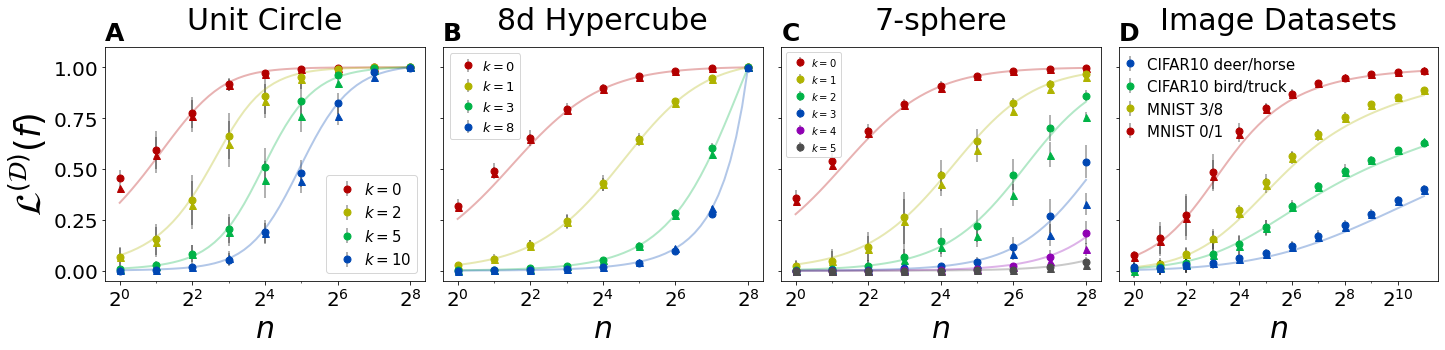

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, (ax, domain) in enumerate(zip(axs, domains+['image_datasets'])):
  ax.set_xscale('symlog', linthreshx=1)

  if domain != 'image_datasets':
    ks = metadata[domain]['th']['ks']
    colors = {ks[i] : hsv_to_rgb(([0,.17,.4,.6,.8,.9][i],1,.7)) for i in range(len(ks))}
    if domain == 'hypersphere':
      colors[5] = (.3,.3,.3)
    ns_th = [n for n in metadata[domain]['th']['ns'] if n >= 1]
    ns_exp = np.array([n for n in metadata[domain]['exp']['ns'] if n >= 1])
    for k in ks:
      lrns_th = [results[domain]['th'][(k, n)]['lrn'] for n in ns_th]
      lrns_k_mean, lrns_k_std = np.array([results[domain]['exp'][(k, n)]['kernel']['lrn'] for n in ns_exp]).T
      lrns_n_mean, lrns_n_std = np.array([results[domain]['exp'][(k, n)]['net']['lrn'] for n in ns_exp]).T
      ax.errorbar(ns_exp, lrns_n_mean, yerr=lrns_n_std, fmt='o', color=colors[k], ecolor=(0,0,0,.3), markersize=7, elinewidth=2, label=f'$k={k}$')
      ax.errorbar(ns_exp, lrns_k_mean, yerr=lrns_k_std, fmt='^', color=colors[k], ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
      ax.plot(ns_th, lrns_th, color=opacify(colors[k], alpha=.3), lw=2)
  
  else:
    tasks = [('mnist',(0,1)), ('mnist',(3,8)), ('cifar10',(2,9)), ('cifar10',(4,7))]
    class_names = {'mnist': range(10), 'cifar10':['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']}
    colors = {tasks[i] : hsv_to_rgb(([0,.17,.4,.6][i],1,.7)) for i in range(len(tasks))}
    ns_th = [n for n in metadata[domain]['th']['ns'] if n <= 2**11 + 1]
    ns_exp = np.array([n for n in metadata[domain]['exp']['ns'] if n <= 2**11 + 1])
    for task in tasks:
      lrns_th = [(results[domain]['th'][(task[0], task[1], n)]['lrn'] - n/10000) / (1 - n/10000) for n in ns_th]
      lrns_k_mean, lrns_k_std = np.array([results[domain]['exp'][(task[0], task[1], n)]['kernel']['lrn'] for n in ns_exp]).T
      lrns_n_mean, lrns_n_std = np.array([results[domain]['exp'][(task[0], task[1], n)]['net']['lrn'] for n in ns_exp]).T
      ax.errorbar(ns_exp, lrns_n_mean, yerr=lrns_n_std, fmt='o', color=colors[task], ecolor=(0,0,0,.3), markersize=7, elinewidth=2, label=f'{task[0].upper()} {class_names[task[0]][task[1][0]]}/{class_names[task[0]][task[1][1]]}')
      ax.errorbar(ns_exp, lrns_k_mean, yerr=lrns_k_std, fmt='^', color=colors[task], ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
      ax.plot(ns_th, lrns_th, color=opacify(colors[task], alpha=.3), lw=2)
      
  ax.legend(ncol=1, fontsize=[15,13,10,13][i], handletextpad=.1, frameon=True)

  if domain == 'image_datasets':
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), fontsize=15, handletextpad=.1, frameon=False, loc=(-.03,.58))

  ax.set_xticks([2**i for i in range(0, round(math.log2(max(ns_exp))+1), 2)], minor=False)
  ax.set_xticks([2**i for i in range(1, round(math.log2(max(ns_exp))-1), 2)], minor=True)
  ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(0, round(math.log2(max(ns_exp))+1), 2)], minor=False)
  ax.set_xticklabels([], minor=True)
  ax.tick_params(axis='both', which='major', labelsize=20)
  if i > 0:
    ax.set_yticklabels([])
  ax.set_ylim((-.05, 1.1))

  ax.set_xlabel('$n$', fontsize=30)
  if i == 0:
    ax.set_ylabel(r'$\mathcal{L}^{(\mathcal{D})}(f)$', fontsize=35)
  
  title = ['Unit Circle', '8d Hypercube', '7-sphere', 'Image Datasets'][i]
  ax.set_title(title, fontsize=30, y=1.05)
  ax.text(.03, 1.03, 'ABCD'[i], transform=ax.transAxes, size=25, weight='bold', ha='center')

fig.tight_layout()

plt.savefig('lrn_curves.pdf')

### Image data MSE plot

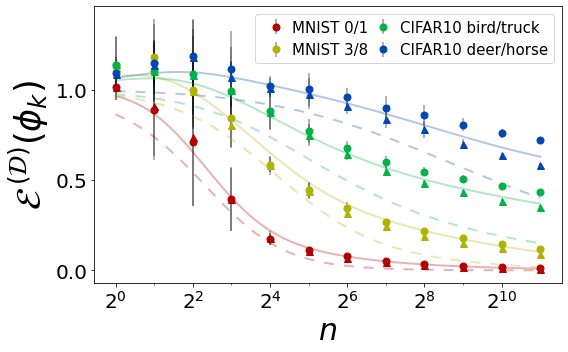

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

domain = 'image_datasets'

tasks = [('mnist',(0,1)), ('mnist',(3,8)), ('cifar10',(2,9)), ('cifar10',(4,7))]
class_names = {'mnist': range(10), 'cifar10':['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']}
colors = {tasks[i] : hsv_to_rgb(([0,.17,.4,.6][i],1,.7)) for i in range(len(tasks))}
ns_th = [n for n in metadata[domain]['th']['ns']]
ns_exp = np.array([n for n in metadata[domain]['exp']['ns']])
for task in tasks:
  lrns_th = np.array([(results[domain]['th'][(task[0], task[1], n)]['lrn'] - n/10000) / (1 - n/10000) for n in ns_th])
  mses_th = [results[domain]['th'][(task[0], task[1], n)]['mse'] / (1 - n/10000) for n in ns_th]
  mses_k_mean, mses_k_std = np.array([results[domain]['exp'][(task[0], task[1], n)]['kernel']['mse'] for n in ns_exp]).T
  mses_n_mean, mses_n_std = np.array([results[domain]['exp'][(task[0], task[1], n)]['net']['mse'] for n in ns_exp]).T

  ax.errorbar(ns_exp, mses_n_mean, yerr=mses_n_std, fmt='o', color=colors[task], ecolor=(0,0,0,.3), markersize=7, elinewidth=2, label=f'{task[0].upper()} {class_names[task[0]][task[1][0]]}/{class_names[task[0]][task[1][1]]}')
  ax.errorbar(ns_exp, mses_k_mean, yerr=mses_k_std, fmt='^', color=colors[task], ecolor=(0,0,0,.3), markersize=7, elinewidth=2)
  ax.plot(ns_th, mses_th, color=opacify(colors[task], alpha=.3), lw=2)
  ax.plot(ns_th, (1 - lrns_th)**2, color=opacify(colors[task], alpha=.3), lw=2, linestyle=(0,(5,5)))

ax.legend(ncol=2, fontsize=15, handletextpad=.1, columnspacing=0)

ax.set_xscale('log')
ax.set_xticks([2**i for i in range(0, round(math.log2(max(ns_exp))+1), 2)], minor=False)
ax.set_xticks([2**i for i in range(1, round(math.log2(max(ns_exp))-1), 2)], minor=True)
ax.set_xticklabels(['$2^{'+str(i)+'}$' for i in range(0, round(math.log2(max(ns_exp))+1), 2)], minor=False)
ax.set_xticklabels([], minor=True)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlabel('$n$', fontsize=30)
ax.set_ylabel(r'$\mathcal{E} \, ^{(\mathcal{D})}(\phi_k)$', fontsize=35)

fig.tight_layout()

plt.savefig('image_mse_curves.pdf')